In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.stats import norm
from tqdm.notebook import tqdm

In [2]:
#work around all those python directory crazyness in order to access the ab_testing module
import os
import sys
import inspect

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir)

from ab_testing.stratification.stratification import stratified_ttest, get_stratified_statistics

# Stratification in AB testing

bla bla bla explain the math based on CUPED paper

In [3]:
"""
Simulating some AB test data where stratification should be helpful

"""

size = 30000

base = np.concatenate([
    norm(loc=8, scale=1).rvs(size=size),
    norm(loc=11, scale=1).rvs(size=size),
])
strata_base = np.concatenate([
    np.array([0] * size),
    np.array([1] * size)
])

variant = np.concatenate([
    norm(loc=8, scale=1).rvs(size=size),
    norm(loc=11.5, scale=1).rvs(size=size),
])
strata_variant = strata_base.copy()

df_base = pd.DataFrame.from_dict(data={"obs": base, "stratum": strata_base})
df_variant = pd.DataFrame.from_dict(data={"obs": variant, "stratum": strata_variant})


df_base

,obs,stratum
0,8.692970,0
1,7.858683,0
2,7.640966,0
3,9.839185,0
4,5.793745,0
...,...,...
59995,10.014798,1
59996,10.684432,1
59997,11.367464,1
59998,10.960347,1


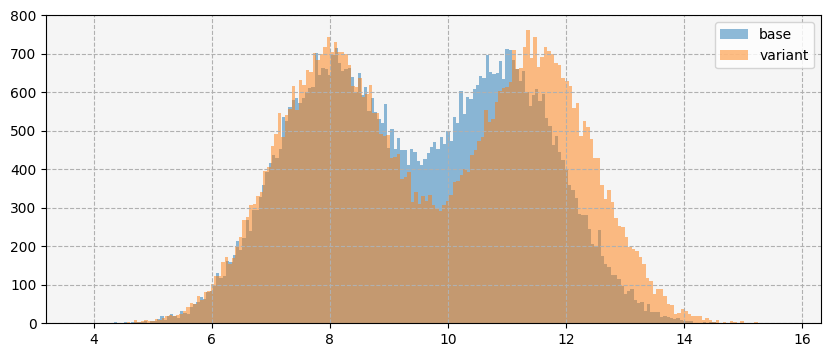

In [4]:
"""
Visualize the data
"""

def hist_base_and_variant(df_base, df_variant):
    fig, ax = plt.subplots(1, 1, figsize=(10, 4))

    ax.hist(df_base.obs, bins=200, alpha=.5, label="base")
    ax.hist(df_variant.obs, bins=200, alpha=.5, label="variant")
    ax.legend()
    ax.grid(True, linestyle="--")
    ax.set_facecolor("whitesmoke")
    plt.show()
    
hist_base_and_variant(df_base, df_variant)

In [5]:
def hist_bootstrap_diff_in_means(df_base, df_variant, n_bootstraps, n_samples_per_bootstrap, weights):
    """
    Bootstrapping of sample means in the standard and stratified way 
    """
    means = np.array([])
    strat_means = np.array([])
    
    for i in tqdm(range(n_bootstraps)):
            
            mean_base = df_base.obs.sample(n=n_samples_per_bootstrap, replace=True, ignore_index=True).mean()
            mean_variant = df_variant.obs.sample(n=n_samples_per_bootstrap, replace=True, ignore_index=True).mean()
            means = np.append(means, mean_variant - mean_base)
    
            sample_base = df_base.sample(n=n_samples_per_bootstrap, replace=True, ignore_index=True)
            sample_variant = df_variant.sample(n=n_samples_per_bootstrap, replace=True, ignore_index=True)
            strat_mean_base, _ = get_stratified_statistics(sample_base.obs, sample_base.stratum, weights=weights)
            strat_mean_variant, _ = get_stratified_statistics(sample_variant.obs, sample_variant.stratum, weights=weights)
            strat_means = np.append(strat_means, strat_mean_variant - strat_mean_base)
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 4))

    ax.hist(means, bins=100, alpha=.5, label="no stratification")
    ax.hist(strat_means, bins=100, alpha=.5, label="stratified")
    ax.set_facecolor("whitesmoke")
    ax.grid(True, linestyle="--")
    ax.set_xlabel("sample mean")
    ax.set_ylabel("n observations")
    ax.set_title(f"Distribution of {n_bootstraps} bootstrapped sample means with sample size {n_samples_per_bootstrap}")
    ax.legend()
    plt.show()

  0%|          | 0/10000 [00:00<?, ?it/s]

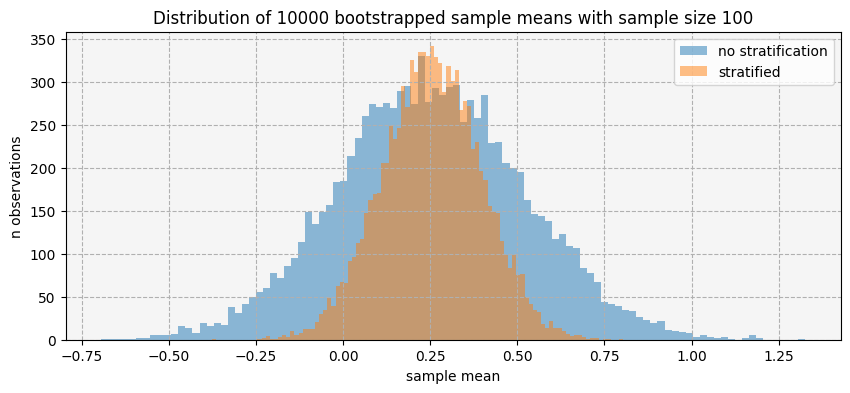

In [6]:
"""
stratification has a clear effect
"""

hist_bootstrap_diff_in_means(df_base, df_variant, 10000, 100, {0: .5, 1: .5})

  0%|          | 0/10000 [00:00<?, ?it/s]

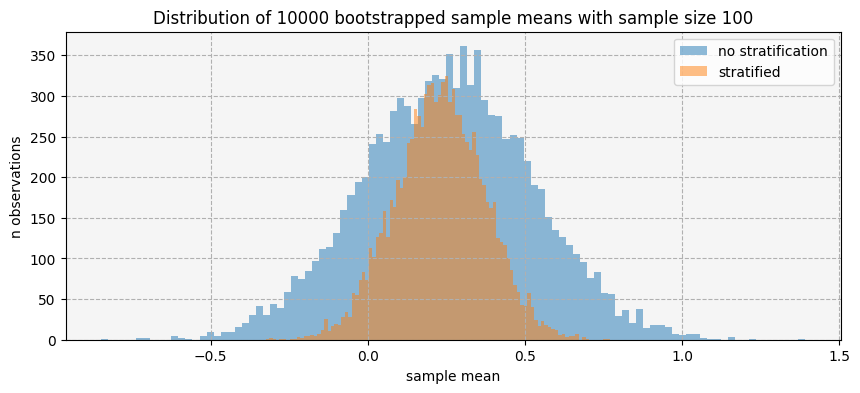

In [7]:
"""
When estimating the weights wrongly, the stratified mean estimator is no longer unbiased 
"""

hist_bootstrap_diff_in_means(df_base, df_variant, 10000, 100, {0: .55, 1: .45})

  0%|          | 0/10000 [00:00<?, ?it/s]

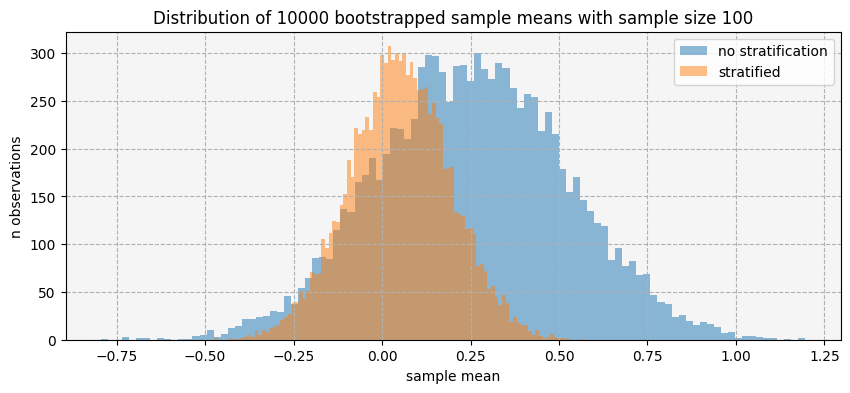

In [8]:
"""
Same as before, but more drastic
"""
hist_bootstrap_diff_in_means(df_base, df_variant, 10000, 100, {0: .7, 1: .1})

  0%|          | 0/10000 [00:00<?, ?it/s]

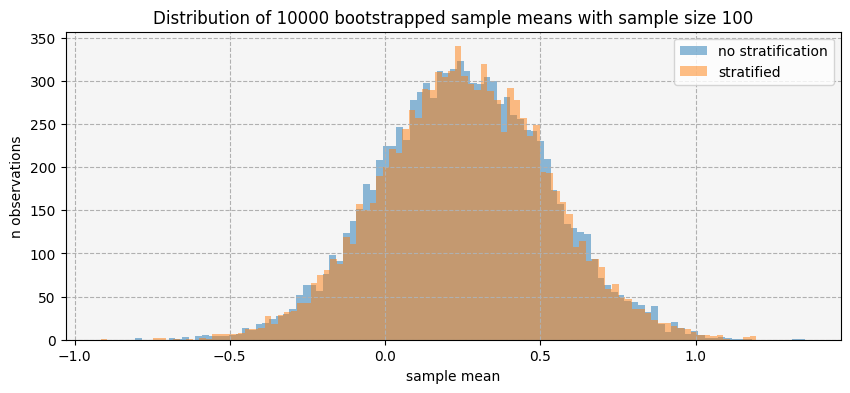

In [9]:
"""
Confirming that when estimating the weights simply from the sample data, stratification has no effect
"""

def hist_bootstrap_diff_in_means_weights_from_sample(
    df_base, df_variant, n_bootstraps, n_samples_per_bootstrap
):
    """
    Bootstrapping of sample means in the standard and stratified way 
    """
    means = np.array([])
    strat_means = np.array([])
    
    for i in tqdm(range(n_bootstraps)):
            
            mean_base = df_base.obs.sample(n=n_samples_per_bootstrap, replace=True, ignore_index=True).mean()
            mean_variant = df_variant.obs.sample(n=n_samples_per_bootstrap, replace=True, ignore_index=True).mean()
            means = np.append(means, mean_variant - mean_base)
    
            sample_base = df_base.sample(n=n_samples_per_bootstrap, replace=True, ignore_index=True)
            sample_variant = df_variant.sample(n=n_samples_per_bootstrap, replace=True, ignore_index=True)
            # we estiamte the weights based on the variant data
            weights_variant = {
                0: sample_variant.query("stratum == 0").shape[0] / sample_variant.shape[0],
                1: sample_variant.query("stratum == 1").shape[0] / sample_variant.shape[0], 
            }
            weights_base = {
                0: sample_base.query("stratum == 0").shape[0] / sample_base.shape[0],
                1: sample_base.query("stratum == 1").shape[0] / sample_base.shape[0], 
            }
            strat_mean_base, _ = get_stratified_statistics(
                sample_base.obs, sample_base.stratum, weights=weights_base
            )
            strat_mean_variant, _ = get_stratified_statistics(
                sample_variant.obs, sample_variant.stratum, weights=weights_variant
            )
            strat_means = np.append(strat_means, strat_mean_variant - strat_mean_base)
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 4))

    ax.hist(means, bins=100, alpha=.5, label="no stratification")
    ax.hist(strat_means, bins=100, alpha=.5, label="stratified")
    ax.set_facecolor("whitesmoke")
    ax.grid(True, linestyle="--")
    ax.set_xlabel("sample mean")
    ax.set_ylabel("n observations")
    ax.set_title(f"Distribution of {n_bootstraps} bootstrapped sample means with sample size {n_samples_per_bootstrap}")
    ax.legend()
    plt.show()
    
hist_bootstrap_diff_in_means_weights_from_sample(df_base, df_variant, 10000, 100)

  0%|          | 0/10000 [00:00<?, ?it/s]

{0: 0.54, 1: 0.46}
{0: 0.5, 1: 0.5}
{0: 0.58, 1: 0.42}
{0: 0.62, 1: 0.38}
{0: 0.46, 1: 0.54}
{0: 0.52, 1: 0.48}


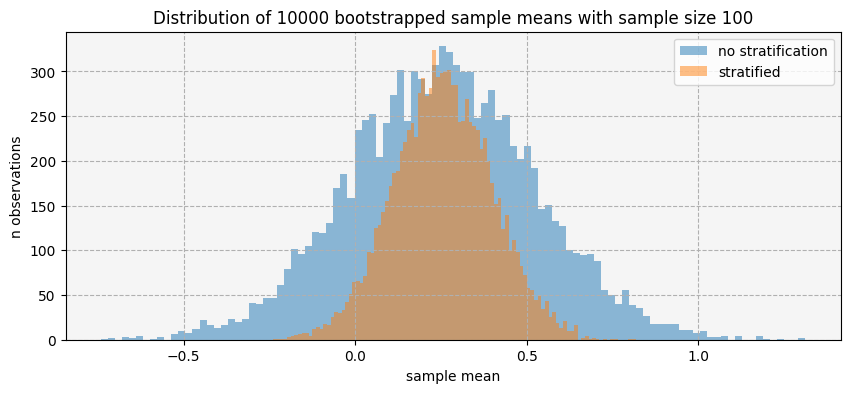

In [10]:
"""
However, infering wheights from the control group and using them for control and variant does work interestingly
"""

def hist_bootstrap_diff_in_means_weights_from_base(
    df_base, df_variant, n_bootstraps, n_samples_per_bootstrap
):
    """
    Bootstrapping of sample means in the standard and stratified way 
    """
    means = np.array([])
    strat_means = np.array([])
    
    for i in tqdm(range(n_bootstraps)):
            
            mean_base = df_base.obs.sample(n=n_samples_per_bootstrap, replace=True, ignore_index=True).mean()
            mean_variant = df_variant.obs.sample(n=n_samples_per_bootstrap, replace=True, ignore_index=True).mean()
            means = np.append(means, mean_variant - mean_base)
    
            sample_base = df_base.sample(n=n_samples_per_bootstrap, replace=True, ignore_index=True)
            sample_variant = df_variant.sample(n=n_samples_per_bootstrap, replace=True, ignore_index=True)
            # we estiamte the weights based on the variant data
            weights_base = {
                0: sample_base.query("stratum == 0").shape[0] / sample_base.shape[0],
                1: sample_base.query("stratum == 1").shape[0] / sample_base.shape[0], 
            }
            if i <= 5:
                print(weights_base)
            strat_mean_base, _ = get_stratified_statistics(
                sample_base.obs, sample_base.stratum, weights=weights_base
            )
            strat_mean_variant, _ = get_stratified_statistics(
                sample_variant.obs, sample_variant.stratum, weights=weights_base
            )
            strat_means = np.append(strat_means, strat_mean_variant - strat_mean_base)
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 4))

    ax.hist(means, bins=100, alpha=.5, label="no stratification")
    ax.hist(strat_means, bins=100, alpha=.5, label="stratified")
    ax.set_facecolor("whitesmoke")
    ax.grid(True, linestyle="--")
    ax.set_xlabel("sample mean")
    ax.set_ylabel("n observations")
    ax.set_title(f"Distribution of {n_bootstraps} bootstrapped sample means with sample size {n_samples_per_bootstrap}")
    ax.legend()
    plt.show()
    
hist_bootstrap_diff_in_means_weights_from_base(df_base, df_variant, 10000, 100)